In [1]:
import numpy as np
import pandas as pd

train_data = pd.read_csv("train_set.csv", index_col=None)
test_data = pd.read_csv("test_set.csv", index_col=None)

In [2]:
train_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
train_log = pd.read_csv("raw_data/test_log.csv", index_col=None)
train_log.drop(columns=['session_id', 'action', 'object', 'time', 'username'], inplace=True)
train_log.drop_duplicates(inplace=True)

test_log = pd.read_csv("raw_data/test_log.csv", index_col=None)
test_log.drop(columns=['session_id', 'action', 'object', 'time', 'username'], inplace=True)
test_log.drop_duplicates(inplace=True)

In [4]:
train_data.sort_values(by='enroll_id', inplace=True)
test_data.sort_values(by='enroll_id', inplace=True)

In [5]:
log = pd.concat([test_log, train_log], ignore_index=True)
temp_test_data = test_data.copy()
temp_test_data['truth'] = -1
user_data = pd.concat([train_data, temp_test_data], ignore_index=True)

In [6]:
index_count = 0
key_nodes = {}

train_key_nodes = {}
for i in train_data['enroll_id'].values:
    if i not in train_key_nodes:
        train_key_nodes[i] = index_count
        key_nodes[i] = index_count
        index_count += 1

test_key_nodes = {}
for i in test_data['enroll_id'].values:
    if i not in train_key_nodes:
        test_key_nodes[i] = index_count
        key_nodes[i] = index_count
        index_count += 1

In [7]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


# Tìm các cặp enroll_id học chung ít nhất một course
course_groups = log.groupby("course_id")["enroll_id"].apply(list)

In [8]:
# Tạo danh sách các cạnh (source_nodes và target_nodes)
edges = []
for enroll_ids in course_groups:
    # Nếu có từ 2 enroll_id trở lên, tạo các cặp
    if len(enroll_ids) > 1:
        for i in range(len(enroll_ids)):
            for j in range(i + 1, len(enroll_ids)):
                edges.append((enroll_ids[i], enroll_ids[j]))

# Chuyển edges thành source_nodes và target_nodes
source_nodes, target_nodes = zip(*edges)

In [9]:
source_nodes = [key_nodes[i] for i in source_nodes]
target_nodes = [key_nodes[i] for i in target_nodes]

In [10]:
edge_index = torch.tensor([source_nodes, 
                           target_nodes], dtype=torch.long)

In [11]:
len(source_nodes)

60129559

In [12]:
node_labels = torch.tensor(user_data['truth'].values, dtype=torch.float)

In [13]:
len(node_labels)

225642

In [14]:
node_features = torch.tensor(user_data.drop(columns=['truth', 'enroll_id']).values, dtype=torch.float)

In [15]:
len(node_features[0])

10

In [16]:
data = Data(x=node_features, edge_index=edge_index, y=node_labels)

# Huấn luyện mô hình

In [17]:
class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 1)  # 1 output cho nhãn nhị phân

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)  # Xác suất nhãn 1

In [18]:
train_mask = data.y != -1

In [19]:
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [20]:
train_mask
len(train_mask)

225642

In [21]:
len(data.x[0])

10

In [22]:
# Khởi tạo mô hình
model = GNNClassifier(input_dim=10, hidden_dim=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()  # Binary Cross-Entropy Loss

# Tách node chưa nhãn ra khỏi tập huấn luyện
train_mask = data.y != -1  # Chỉ dùng node có nhãn để huấn luyện

# Huấn luyện mô hình
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data).squeeze()
    loss = loss_fn(out[train_mask], data.y[train_mask])  # Chỉ tính loss trên node có nhãn
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 20, Loss: 3.1225
Epoch 40, Loss: 0.8000
Epoch 60, Loss: 0.5740
Epoch 80, Loss: 0.4913
Epoch 100, Loss: 0.4822
Epoch 120, Loss: 0.4736
Epoch 140, Loss: 0.4659
Epoch 160, Loss: 0.4595
Epoch 180, Loss: 0.4538
Epoch 200, Loss: 0.4482


In [23]:
# Đặt mô hình ở chế độ dự đoán
model.eval()
predictions = model(data).squeeze()


In [24]:
# Dự đoán nhãn (0 hoặc 1) của node mới
new_node_probability = predictions[-67699:]

In [25]:
new_node_probability

tensor([0.7271, 0.7276, 0.7280,  ..., 0.9041, 0.9047, 0.9052],
       grad_fn=<SliceBackward0>)

In [26]:
numpy_array = new_node_probability.detach().numpy()

result = (numpy_array >= 0.5).astype(int)
result

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_data['truth'].values.ravel(), result)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73


In [28]:
from sklearn.metrics import classification_report

# Tạo classification report
report = classification_report(test_data['truth'].values.ravel(), result)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.41      0.43     16383
           1       0.82      0.84      0.83     51316

    accuracy                           0.73     67699
   macro avg       0.63      0.62      0.63     67699
weighted avg       0.73      0.73      0.73     67699



In [29]:
data.num_edges

60129559

In [30]:
data.num_nodes

225642

In [31]:
len(user_data)

225642

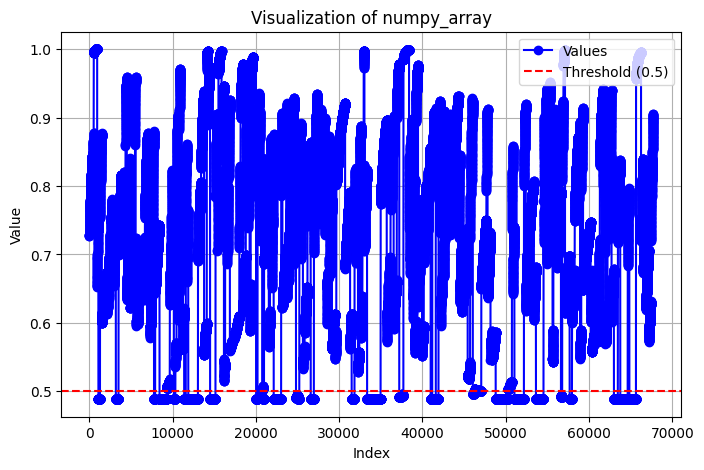

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Plot dữ liệu
plt.figure(figsize=(8, 5))
plt.plot(numpy_array, marker='o', linestyle='-', color='b', label='Values')
plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
plt.title('Visualization of numpy_array')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
log

,enroll_id,course_id
0,775,course-v1:TsinghuaX+70800232X+2015_T2
1,778,course-v1:TsinghuaX+70800232X+2015_T2
2,784,course-v1:TsinghuaX+70800232X+2015_T2
3,788,course-v1:TsinghuaX+70800232X+2015_T2
4,797,course-v1:TsinghuaX+70800232X+2015_T2
...,...,...
135393,466770,course-v1:TsinghuaX+AP000001X+2016_T1
135394,466775,course-v1:TsinghuaX+AP000001X+2016_T1
135395,466777,course-v1:TsinghuaX+AP000001X+2016_T1
135396,466783,course-v1:TsinghuaX+AP000001X+2016_T1


In [36]:
user_data

,enroll_id,gender,education,age,prev_dropout_num,previous_enroll_num,previous_dropout_user_num,duration,session_num,video_num,courseware_num,truth
0,772,0,1,26.0,1,25,25,103,1,0,0,1
1,773,1,0,18.0,1,561,523,103,1,14,3,1
2,774,0,0,18.0,1,850,711,103,3,42,26,1
3,776,1,3,34.0,1,716,637,103,1,9,6,0
4,777,0,0,18.0,1,223,212,103,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
225637,466770,1,0,19.0,1,20,20,120,2,33,9,-1
225638,466775,0,0,19.0,0,8,8,120,2,0,2,-1
225639,466777,0,0,16.0,0,22,22,120,2,6,6,-1
225640,466783,1,0,19.0,0,1,1,120,1,0,0,-1


In [34]:
user_data.drop(columns=['truth', 'enroll_id']).columns

Index(['gender', 'education', 'age', 'prev_dropout_num', 'previous_enroll_num',
       'previous_dropout_user_num', 'duration', 'session_num', 'video_num',
       'courseware_num'],
      dtype='object')

In [35]:
# In thông tin của đồ thị
print("Thông tin cơ bản về đồ thị:")
print(data)

# Truy cập thông tin chi tiết
print("\nSố lượng nút:", data.num_nodes)
print("Số cạnh:", data.num_edges)
print("Danh sách các cạnh:")
print(data.edge_index)

print("\nNhãn của các node (y):")
print(data.y)

print("Đồ thị có hướng không?", data.is_directed())

Thông tin cơ bản về đồ thị:
Data(x=[225642, 10], edge_index=[2, 60129559], y=[225642])

Số lượng nút: 225642
Số cạnh: 60129559
Danh sách các cạnh:
tensor([[172031, 172031, 172031,  ..., 220160, 220160, 220161],
        [172032, 172033, 172034,  ..., 220161, 220162, 220162]])

Nhãn của các node (y):
tensor([ 1.,  1.,  1.,  ..., -1., -1., -1.])
Đồ thị có hướng không? True


In [37]:
user_data[['enroll_id', 'truth']]

,enroll_id,truth
0,772,1
1,773,1
2,774,1
3,776,0
4,777,1
...,...,...
225637,466770,-1
225638,466775,-1
225639,466777,-1
225640,466783,-1
